# 1st COMputing CHAllenges School <a class="tocSkip">

## ML Challenge - baseline solution <a class="tocSkip">
  
*Barcelona, October 7th, 2019*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-basetrack-dataset" data-toc-modified-id="Load-basetrack-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load basetrack dataset</a></span></li><li><span><a href="#Load-electromagnetic-shower-info" data-toc-modified-id="Load-electromagnetic-shower-info-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load electromagnetic shower info</a></span></li><li><span><a href="#Basic-implementation" data-toc-modified-id="Basic-implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic implementation</a></span><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Test-the-model" data-toc-modified-id="Test-the-model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Test the model</a></span></li></ul></li></ul></div>

# Load basetrack dataset

Import dataset containing basetrack information:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('data/DS_1_train.csv')

print('Total basetracks:', len(df))
df.head()

Total basetracks: 1123177


,event_id,X,Y,Z,TX,TY,chi2,signal
0,-999,42720.238281,75152.406250,32325.0,-0.475539,0.405506,2.652586,0.0
1,-999,46023.816406,37043.359375,21981.0,0.330822,-0.013988,2.497527,0.0
2,-999,52706.117188,33872.730469,16809.0,0.342634,-0.058724,2.120421,0.0
3,-999,47334.101562,9698.531250,60771.0,0.007868,-0.632822,0.618535,0.0
4,-999,67380.835938,19137.265625,37497.0,-0.212537,-0.192243,2.799303,0.0


Basetracks coming from a signal electromagnetic shower are flagged with ``signal=1.0``:

In [10]:
print('Signal basetracks:', len(df[df.signal==1]))

df[df.signal==1].head()

Signal basetracks: 51018


,event_id,X,Y,Z,TX,TY,chi2,signal
29,411,53290.710938,22941.925781,63357.0,-0.258045,0.710882,1.846556,1.0
32,27354,36921.367188,21285.517578,72408.0,-0.924607,0.819380,0.849372,1.0
37,5586,43593.214844,56103.648438,45255.0,-0.330734,-0.467480,0.646188,1.0
39,3009,54343.628906,49445.316406,42669.0,0.242685,-0.080539,0.413605,1.0
41,739,41051.804688,34390.445312,60771.0,0.035552,-0.042680,0.670655,1.0


Variable ``event_id`` is set to -999 for background basetracks. For signal events it denotes the event number:

In [15]:
print('N. of basetracks associated to event 411:', len(df[df.event_id==411]))

df[df.event_id==411].head()

N. of basetracks associated to event 411: 3029


,event_id,X,Y,Z,TX,TY,chi2,signal
29,411,53290.710938,22941.925781,63357.0,-0.258045,0.710882,1.846556,1.0
200,411,54048.312500,21494.039062,67236.0,-0.212128,0.848217,0.276276,1.0
419,411,54261.937500,19153.699219,46548.0,-0.058761,0.044806,0.946251,1.0
1508,411,54349.023438,21567.351562,72408.0,-0.517587,0.361877,2.742453,1.0
1739,411,54467.324219,20009.087891,55599.0,-0.029864,0.079060,0.732168,1.0


NB: *X, Y, Z, TX, TY, chi2* of basetrack dataset are the only variables we are allowed to use as training features (and any other engineered feature derived from them).

# Load electromagnetic shower info

Now we load the dataset containing the coordinate of mother particles of 100 electromagnetic shower events. 

NB: this is MC truth information!

In [4]:
df_electron = pd.read_csv('data/DS_1_electron_train.csv')

In [20]:
print(len(df_electron))
df_electron.head()

100


,event_id,P,X,Y,Z,TX,TY
0,43311,6.059411,50445.277344,18868.576172,32163.242188,-0.145684,-0.044486
1,44301,4.829437,44404.660156,24444.984375,10518.998047,-0.044544,0.132461
2,41829,4.929091,49269.140625,45781.617188,37460.796875,0.060940,0.101490
3,38613,1.587992,44798.660156,43921.625000,35979.109375,-0.332825,0.115194
4,18087,7.594307,45228.773438,43913.035156,28341.851562,0.021005,0.058128


As an example, we look at the mother particle which originates the electromagnetic shower identified as event 411:

In [19]:
df_electron[df_electron.event_id==411]

,event_id,P,X,Y,Z,TX,TY
70,411,81.597618,54071.785156,17360.886719,27072.421875,0.010623,0.085938


# Basic implementation

As a baseline for the challenge, we implement a Decision Tree classifier which **only uses** ``chi2`` variable as training feature and **no information** on the mother particles.

## Prepare data


First of all, we split the dataset in a training and a test sample (keep this splitting to train/test your model!):

In [25]:
train_df = df[:1000000]
test_df  = df[1000000:]


print('Train dataset: ', len(train_df))
print('Test dataset:  ', len(test_df))

Train dataset:  1000000
Test dataset:   123177


In [22]:
train_df.head()

,event_id,X,Y,Z,TX,TY,chi2,signal
0,-999,42720.238281,75152.406250,32325.0,-0.475539,0.405506,2.652586,0.0
1,-999,46023.816406,37043.359375,21981.0,0.330822,-0.013988,2.497527,0.0
2,-999,52706.117188,33872.730469,16809.0,0.342634,-0.058724,2.120421,0.0
3,-999,47334.101562,9698.531250,60771.0,0.007868,-0.632822,0.618535,0.0
4,-999,67380.835938,19137.265625,37497.0,-0.212537,-0.192243,2.799303,0.0


Now we extract the feature and target arrays:

In [26]:
X_train = train_df.values[:, 6:7]  # Use only chi2 column as feature
y_train = train_df.values[:, 7:8]

## Train the model

We fit a simple Decision Tree classifier on the train sample:

In [27]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 9)

In [28]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Test the model

Let's evaluate the result of our classifier on the test dataset:

In [29]:
X_test = test_df.values[:, 6:7]
y_test = test_df.values[:, 7:8]

In [37]:
predictions = clf.predict_proba(X_test)

Use the predicted probabilities for each baseline track of the test dataset to compute the ROC curve:

In [38]:
from sklearn.metrics import roc_curve, auc

In [41]:
fpr, tpr, _ = roc_curve(y_test, predictions[:, 1])
roc_auc     = auc(fpr, tpr)
roc_auc

0.8597683975393354

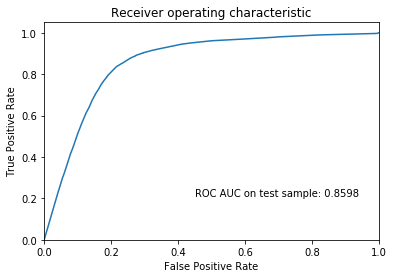

In [42]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.annotate('ROC AUC on test sample: '+str(round(roc_auc, 4)), xy=(0.45, 0.2), xycoords='axes fraction')
plt.show()